https://www.sciencedirect.com/science/article/pii/S1535610824000461?via%3Dihub

In [97]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce  # for harmony
import scanpy as sc
import matplotlib.pyplot as plt

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))  

from scrna_pipeline import standard_scrna_pipeline


In [98]:


# Path to raw AnnData file (adjust as needed)
raw_path = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Zheng_CancerCell_2024/GSE222315_RAW/merged_BCa_NAT.h5ad"

# Read the raw data
adata_raw = sc.read_h5ad(raw_path)

print(adata_raw)
adata_raw.obs.head()

AnnData object with n_obs × n_vars = 103349 × 37458
    obs: 'gsm', 'sample', 'condition', 'batch'
    layers: 'counts'


gsm sample condition       batch
barcode                                                               
GSM6919778:AAACCTGAGCGTCTAT-1  GSM6919778     p1       BCA  GSM6919778
GSM6919778:AAACCTGAGGCAGGTT-1  GSM6919778     p1       BCA  GSM6919778
GSM6919778:AAACCTGAGGTTACCT-1  GSM6919778     p1       BCA  GSM6919778
GSM6919778:AAACCTGAGTGGTAGC-1  GSM6919778     p1       BCA  GSM6919778
GSM6919778:AAACCTGAGTGTGGCA-1  GSM6919778     p1       BCA  GSM6919778

In [99]:
adata_raw.obs["sample"].value_counts()

sample
p2    26795
p5    14570
p4    14395
p3    11046
p1    10386
p9     7210
p8     7054
p7     6101
p6     5792
Name: count, dtype: int64

In [100]:
adata_raw.obs["condition"].value_counts()

condition
BCA    77429
NAT    25920
Name: count, dtype: int64

In [101]:
adata_raw.obs[adata_raw.obs["condition"]=='NAT']['sample'].value_counts()

sample
p2    10675
p4     7455
p5     6407
p3     1383
p1        0
p6        0
p7        0
p8        0
p9        0
Name: count, dtype: int64

In [102]:
adata_raw.obs[adata_raw.obs["condition"]=='BCA']['sample'].value_counts()

sample
p2    16120
p1    10386
p3     9663
p5     8163
p9     7210
p8     7054
p4     6940
p7     6101
p6     5792
Name: count, dtype: int64

In [103]:

# keep_samples = [ "p2"]

# adata_raw = adata_raw[adata_raw.obs["sample"].isin(keep_samples)]
# adata_raw = adata_raw[adata_raw.obs["condition"]=='BCA']

In [109]:
# Choose the column in adata.obs that encodes batch / sample.
# If you have no batches, you can set batch_key=None and batch_method="none".
batch_key = "sample"   # change if your column is named differently

# Run the standard pipeline:
# - QC + filters + Scrublet
# - HVGs (Seurat v3 on counts by default)
# - normalize/log + scale + PCA
# - Harmony batch correction
# - neighbors + Leiden + UMAP
adata_proc = standard_scrna_pipeline(
    adata_raw,
    batch_key=batch_key,

    # batch correction method
    batch_method="harmony",

    # HVG selection
    hvg_flavor= "seurat", #"seurat_v3",
    n_top_genes=2000,

    # clustering
    clustering_method="leiden",

    # 👇 All preprocessing options go here
    preprocess_kwargs={
        "use_ribo_filter": False,
        "use_mito_filter": True
    },
)


print(adata_proc)



[ scrna-pipeline ] Running standard scRNA-seq pipeline
  • Input AnnData shape: 103349 cells × 32417 genes
  • Batch key:         'sample'
  • Batch method:      'harmony'
  • HVG flavor:        'seurat'
  • n_top_genes:       2000
  • n_pcs:             50
  • Clustering:        'leiden'
  • Cluster resol.:    0.6
  • Preprocess kwargs: {'use_mito_filter': True, 'use_ribo_filter': False}
  • Batch kwargs:      {}
  • Cluster kwargs:    {}

Running Scrublet for doublet detection...
Removed 812 predicted doublets
After doublet removal: (96682, 32417)


/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-12-11 09:55:08,796 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


[ scrna-pipeline ] Step 1 complete: preprocess_to_pca
  • PCA stored in .obsm['X_pca']
  • Genes after HVG selection: 2000
  • Cells after QC / Scrublet: 96682

Running Harmony batch correction using batch_key='sample'...


2025-12-11 09:55:12,523 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-11 09:55:12,675 - harmonypy - INFO - Iteration 1 of 10
2025-12-11 09:55:26,568 - harmonypy - INFO - Iteration 2 of 10
2025-12-11 09:55:40,256 - harmonypy - INFO - Iteration 3 of 10
2025-12-11 09:55:53,928 - harmonypy - INFO - Iteration 4 of 10
2025-12-11 09:56:07,844 - harmonypy - INFO - Iteration 5 of 10
2025-12-11 09:56:21,844 - harmonypy - INFO - Iteration 6 of 10
2025-12-11 09:56:35,999 - harmonypy - INFO - Iteration 7 of 10
2025-12-11 09:56:44,444 - harmonypy - INFO - Converged after 7 iterations


[ scrna-pipeline ] Step 2 complete: batch correction with 'harmony'
  • Corrected embedding stored in .obsm['X_pca_harmony']

[ scrna-pipeline ] Step 3 complete: clustering + UMAP
  • Cluster labels in .obs['leiden']
  • UMAP stored in .obsm['X_umap']
  • Final AnnData shape: 96682 cells × 2000 genes

AnnData object with n_obs × n_vars = 96682 × 2000
    obs: 'gsm', 'sample', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'm

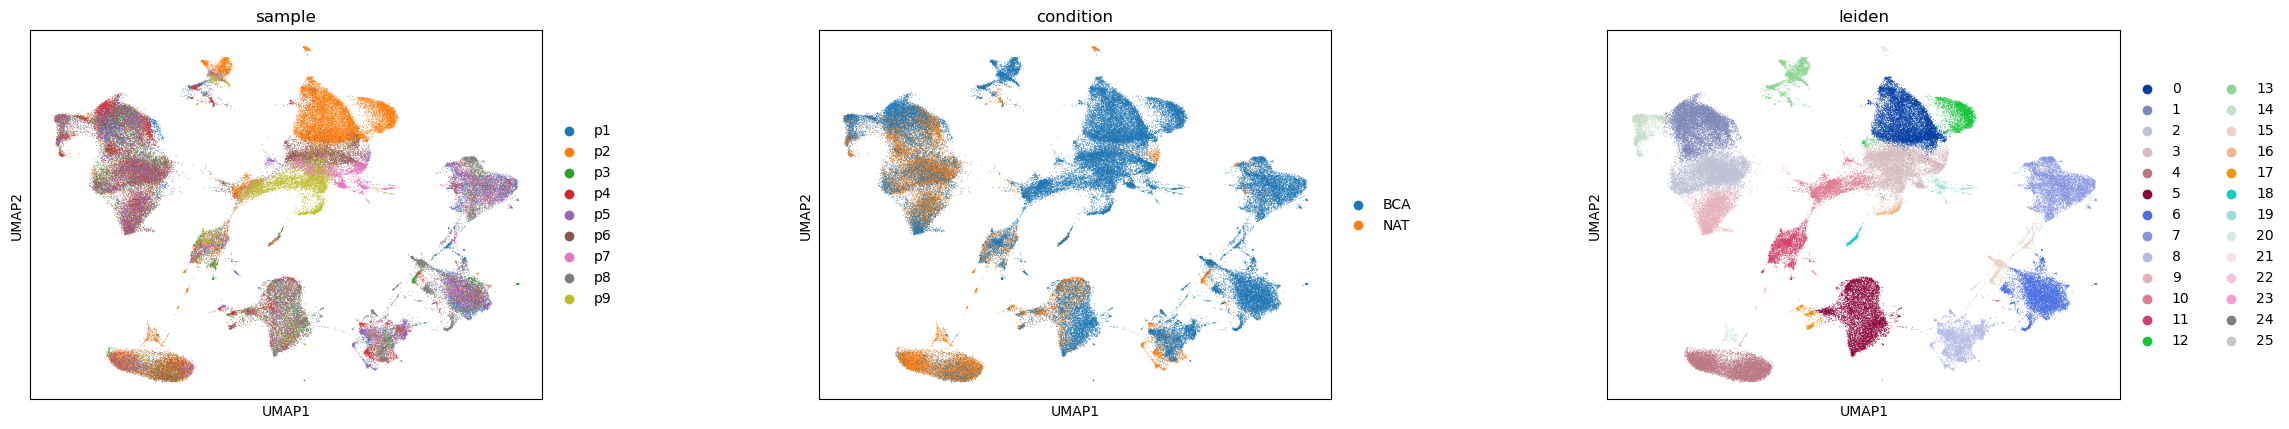

In [110]:
# Quick UMAP overview:
# - color by batch (e.g. "sample")
# - color by cluster ("louvain")
umap_colors = []

if "sample" in adata_proc.obs.columns:
    umap_colors.append("sample")

if "condition" in adata_proc.obs.columns:   # only if present in your data
    umap_colors.append("condition")

if "louvain" in adata_proc.obs.columns:
    umap_colors.append("louvain")

if "leiden" in adata_proc.obs.columns:
    umap_colors.append("leiden")

sc.pl.umap(
    adata_proc,
    color=umap_colors,
    wspace=0.4,
)


In [111]:
from scrna_pipeline.annotation import score_markers_and_suggest_labels

# ------------------------------------------------------------------
# 1) Define marker dictionary
# ------------------------------------------------------------------
marker_dict = {
    # -----------------------
    # Epithelial 
    # -----------------------
    "Epithelial": [
        "EPCAM",   # classic epithelial marker
        "KRT8",
        "KRT18",
        "KRT19",
        "KRT17",
        "KRT5",
        "KRT14",
        "MUC1",    # luminal / glandular epithelial
    ],

    # -----------------------
    # Immune lineages
    # -----------------------
    "T_cell": [
        "CD3D", "CD3E", "CD2", "CD8A", "CD4",
    ],
    "B_cell": [
        "MS4A1", "CD79A", "CD79B",
    ],
    "Myeloid": [
        "LYZ",
        "CD68", "CD14",
        "TYROBP", "LST1",
        "CSF1R", "FCGR3A",
    ],

    # -----------------------
    # Stromal + mast
    # -----------------------
    "Endothelial": [
        "PECAM1", "VWF", "KDR",
    ],
    "Fibroblast": [
        "COL1A1", "COL1A2", "DCN", "LUM",
    ],
    "Mast": [
        "TPSAB1", "TPSB2", "CPA3", "KIT", "HDC", "MS4A2",
    ],
}

# ------------------------------------------------------------------
# 2) Pick a cluster column automatically
# ------------------------------------------------------------------
if "leiden" in adata_proc.obs:
    cluster_key = "leiden"
elif "louvain" in adata_proc.obs:
    cluster_key = "louvain"
elif "cluster" in adata_proc.obs:
    # in case you manually created a generic cluster column
    cluster_key = "cluster"
else:
    raise ValueError(
        "No clustering column found in `adata.obs`. "
        "Expected one of: 'leiden', 'louvain', or 'cluster'."
    )

print(f"Using cluster_key = '{cluster_key}' for marker-based annotation.")

# ------------------------------------------------------------------
# 3) Score markers and get suggested labels
# ------------------------------------------------------------------
cluster_scores, suggested = score_markers_and_suggest_labels(
    adata_proc,
    marker_dict=marker_dict,
    cluster_key=cluster_key,
)

# ------------------------------------------------------------------
# 4) Pretty display (with fallback if styling fails)
# ------------------------------------------------------------------
try:
    display(
        cluster_scores
        .round(2)
        .style
        .background_gradient(cmap="viridis")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            dict(selector="th", props=[("text-align", "center")]),
        ])
    )
except Exception as e:
    # e.g. jinja2 not installed or in non-notebook context
    print("Styled display failed, showing plain table instead:", repr(e))
    display(cluster_scores.round(2))

# If you want, you can also inspect the suggested labels:
suggested


Using cluster_key = 'leiden' for marker-based annotation.


/Users/alahi.irfan/Desktop/Local_workspace/scRNA-seq-pipeline/scrna_pipeline/annotation.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)[score_cols]


leiden
0      Epithelial
1          T_cell
2          T_cell
3      Epithelial
4          B_cell
5         Myeloid
6      Fibroblast
7     Endothelial
8      Fibroblast
9          T_cell
10     Epithelial
11         B_cell
12     Epithelial
13     Epithelial
14         T_cell
15     Fibroblast
16     Epithelial
17        Myeloid
18           Mast
19     Epithelial
20         B_cell
21     Epithelial
22         B_cell
23        Myeloid
24     Fibroblast
25     Fibroblast
dtype: object

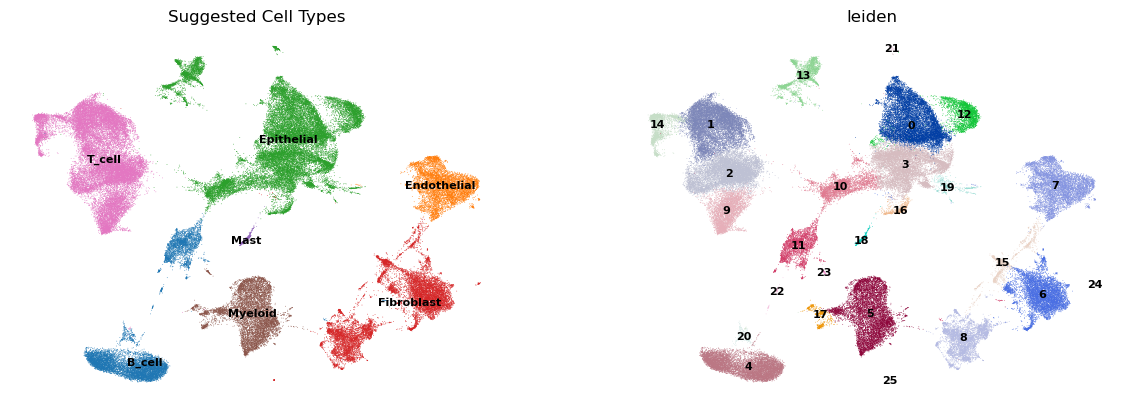

In [112]:


# Attach suggested labels for plotting
adata_proc.obs["celltype"] = adata_proc.obs[cluster_key].map(suggested)


sc.pl.umap(
    adata_proc,
    color=["celltype",cluster_key],
    legend_loc="on data",
    legend_fontsize=8,
    frameon=False,
    title="Suggested Cell Types",
)

Markers present in this dataset: ['EPCAM', 'KRT8', 'KRT18', 'CD3D', 'CD3E', 'MS4A1', 'CD14', 'LYZ', 'CD68', 'TYROBP', 'LST1', 'CSF1R', 'FCGR3A', 'S100A8', 'S100A9', 'COL1A1', 'COL1A2', 'VWF', 'PECAM1', 'IGKC', 'IGHG1', 'JCHAIN', 'MYH11', 'MYL9', 'DES']


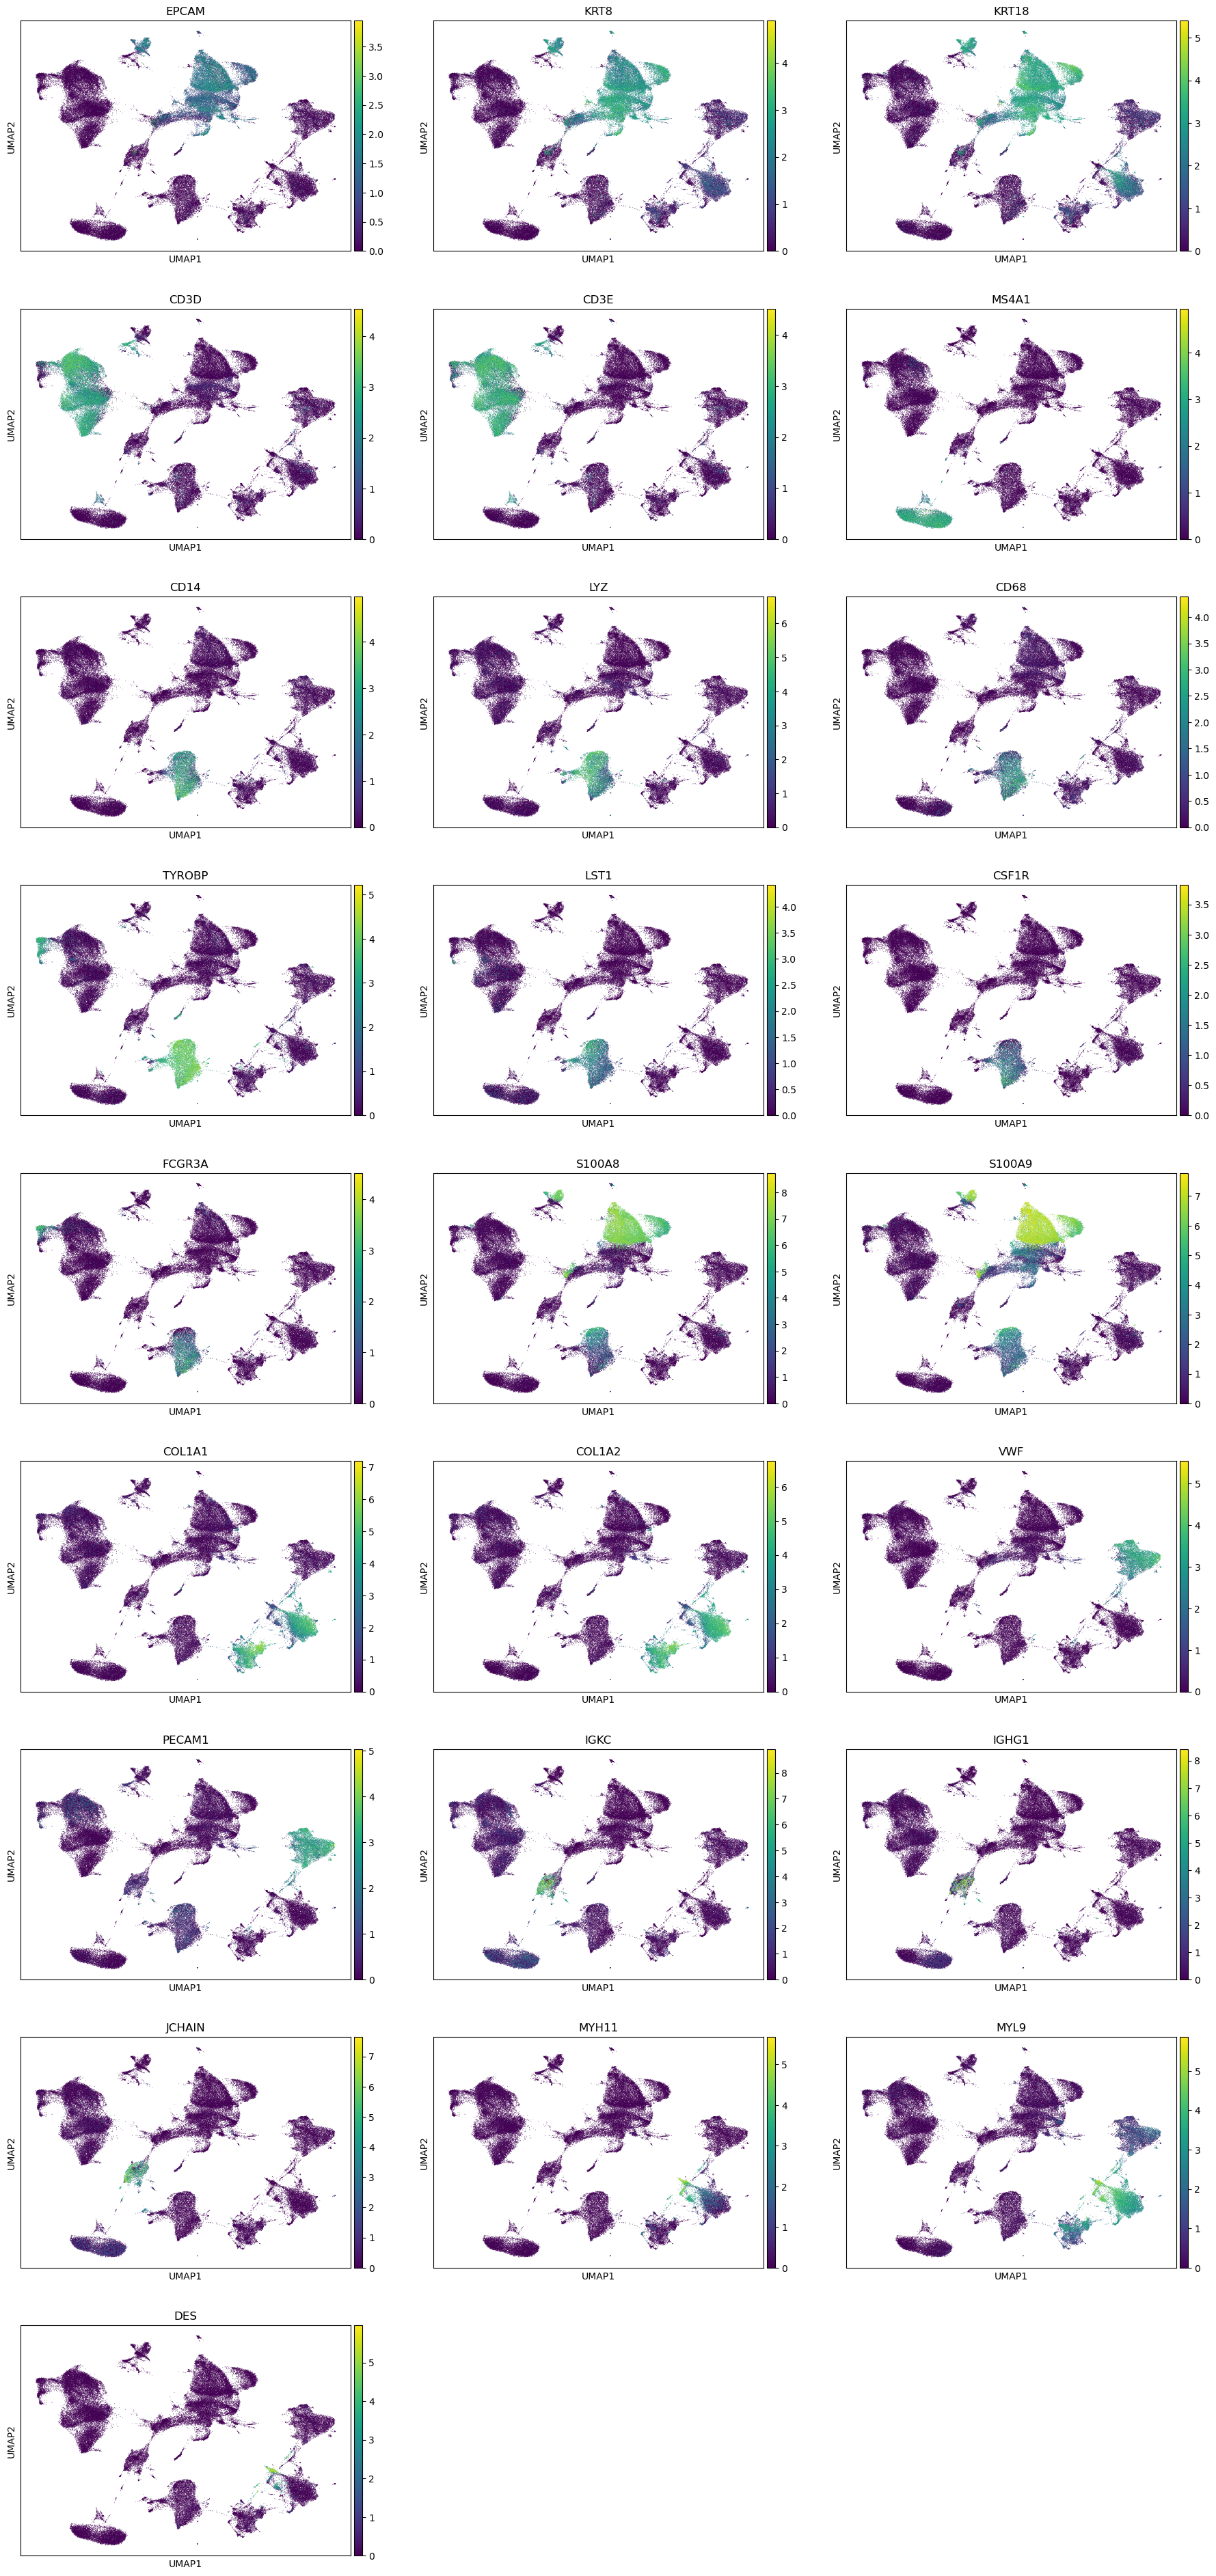

In [113]:
markers = [
    "EPCAM", "KRT8", "KRT18",   # epithelial / tumor
    "CD3D", "CD3E",             # T cells
    "MS4A1",                    # B cells
    "CD14", "LYZ","CD68", "TYROBP", "LST1", "CSF1R", "FCGR3A", "S100A8", "S100A9", # myeloid / monocytes / macrophages
    "COL1A1", "COL1A2",          # fibroblasts / stromal
    "VWF", "PECAM1",             # endothelial 
    "IGKC", "IGHG1", "JCHAIN",   # Plasmocyte
    "MYH11",  "MYL9",   "DES"    # Myocyte
     
]

present = [g for g in markers if g in adata_proc.raw.var_names]
print("Markers present in this dataset:", present)

if present:
    sc.pl.umap(adata_proc, color=present, ncols=3, use_raw=True)
